# Capstone Project: Art Color Intelligence Platform

## Introduction

Congratulations on reaching the final lesson! In this capstone project, you'll build a complete **Art Color Intelligence Platform** that combines everything you've learned across all 16 lessons.

### What You'll Build

A comprehensive system that can:

1. **Analyze** any artwork's color characteristics
2. **Classify** its likely art movement
3. **Find** similar artworks and artists
4. **Generate** new palettes in similar styles
5. **Detect** if it's an anomaly or fits patterns
6. **Estimate** its probable time period
7. **Provide** a complete "Color Intelligence Report"

### Skills Integration

| Lesson | Technique | Application in Capstone |
|--------|-----------|------------------------|
| 1-3 | Color extraction & spaces | Core feature extraction |
| 4-6 | Signatures & harmony | Quality metrics |
| 7-9 | Pipelines & psychology | Report generation |
| 10-11 | Classification & naming | Movement prediction, color names |
| 12 | SHAP explainability | Why this classification? |
| 13 | VAE generation | Style-based palette generation |
| 14 | Artist DNA | Similarity search |
| 15 | Clustering & anomaly | Uniqueness scoring |
| 16 | Temporal analysis | Date estimation |

Let's build something amazing!

## Setup

In [3]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from datetime import datetime
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Renoir imports
from renoir import ArtistAnalyzer
from renoir.color import ColorExtractor, ColorAnalyzer, ColorVisualizer, ColorNamer

# ML imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import seaborn as sns

# Initialize components
artist_analyzer = ArtistAnalyzer()
color_extractor = ColorExtractor()
color_analyzer = ColorAnalyzer()
visualizer = ColorVisualizer()
color_namer = ColorNamer(vocabulary='artist')

# Load dataset
print("Loading WikiArt dataset...")
dataset = artist_analyzer._load_dataset()
print(f"Loaded {len(dataset)} artworks")

# Metadata
style_names = dataset.features['style'].names
artist_names = dataset.features['artist'].names

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
SEED = 42
np.random.seed(SEED)

print("\nSetup complete!")

Loading WikiArt dataset...
Loading WikiArt dataset...


Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/45 [00:00<?, ?it/s]

✓ Loaded 81444 artworks
Loaded 81444 artworks

Setup complete!


## Part 1: Core Feature Extraction Engine

First, let's build a comprehensive feature extraction system that powers all our analyses.

In [4]:
class ColorFeatureEngine:
    """
    Comprehensive color feature extraction engine.
    Combines techniques from Lessons 1-6.
    """
    
    def __init__(self, n_colors=8):
        self.n_colors = n_colors
        self.extractor = ColorExtractor()
        self.analyzer = ColorAnalyzer()
        self.namer = ColorNamer(vocabulary='artist')
    
    def extract_palette(self, image):
        """Extract dominant colors from image."""
        return self.extractor.extract_dominant_colors(image, n_colors=self.n_colors)
    
    def extract_features(self, image):
        """
        Extract comprehensive color features.
        
        Returns:
            dict: Feature dictionary
            list: Color palette
        """
        try:
            palette = self.extract_palette(image)
            if not palette or len(palette) < 3:
                return None, None
            
            # Basic statistics
            stats = self.analyzer.analyze_palette_statistics(palette)
            temp = self.analyzer.analyze_color_temperature_distribution(palette)
            harmony = self.analyzer.analyze_color_harmony(palette)
            
            # HSV analysis
            hsv_colors = [self.analyzer.rgb_to_hsv(c) for c in palette]
            hues = [h[0] for h in hsv_colors]
            sats = [h[1] for h in hsv_colors]
            vals = [h[2] for h in hsv_colors]
            
            # RGB analysis
            reds = [c[0] for c in palette]
            greens = [c[1] for c in palette]
            blues = [c[2] for c in palette]
            
            features = {
                # Central tendencies
                'mean_hue': stats['mean_hue'],
                'mean_saturation': stats['mean_saturation'],
                'mean_brightness': stats['mean_value'],
                'mean_red': np.mean(reds),
                'mean_green': np.mean(greens),
                'mean_blue': np.mean(blues),
                
                # Variability
                'std_hue': np.std(hues),
                'std_saturation': np.std(sats),
                'std_brightness': np.std(vals),
                
                # Temperature
                'warm_ratio': temp['warm_percentage'] / 100,
                'cool_ratio': temp['cool_percentage'] / 100,
                'neutral_ratio': temp['neutral_percentage'] / 100,
                
                # Scores
                'color_diversity': self.analyzer.calculate_color_diversity(palette),
                'saturation_score': self.analyzer.calculate_saturation_score(palette),
                'brightness_score': self.analyzer.calculate_brightness_score(palette),
                
                # Harmony
                'harmony_score': harmony.get('harmony_score', 0),
                'n_complementary': len(harmony.get('complementary_pairs', [])),
                'n_triadic': len(harmony.get('triadic_sets', [])),
                'n_analogous': len(harmony.get('analogous_groups', [])),
                
                # Contrast
                'brightness_range': max(vals) - min(vals),
                'saturation_range': max(sats) - min(sats),
            }
            
            return features, palette
            
        except Exception as e:
            return None, None
    
    def name_palette(self, palette):
        """Get evocative names for palette colors."""
        names = []
        for color in palette:
            # Convert to integer tuple for ColorNamer
            rgb = tuple(int(c) for c in color)
            names.append(self.namer.name(rgb))
        return names
    
    def get_dominant_harmony(self, palette):
        """Determine the dominant harmony type."""
        harmony = self.analyzer.analyze_color_harmony(palette)
        return harmony.get('dominant_harmony', 'none')
    
    def get_mood_keywords(self, features):
        """Generate mood keywords from features (Lesson 9)."""
        keywords = []
        
        # Brightness
        if features['mean_brightness'] > 60:
            keywords.append('luminous')
        elif features['mean_brightness'] < 35:
            keywords.append('somber')
        
        # Saturation
        if features['mean_saturation'] > 50:
            keywords.append('vibrant')
        elif features['mean_saturation'] < 20:
            keywords.append('muted')
        
        # Temperature
        if features['warm_ratio'] > 0.7:
            keywords.append('warm')
        elif features['cool_ratio'] > 0.7:
            keywords.append('cool')
        
        # Diversity
        if features['color_diversity'] > 0.4:
            keywords.append('diverse')
        elif features['color_diversity'] < 0.2:
            keywords.append('focused')
        
        # Contrast
        if features['brightness_range'] > 50:
            keywords.append('dramatic')
        
        return keywords if keywords else ['balanced']


# Test the engine
feature_engine = ColorFeatureEngine()

test_works = artist_analyzer.extract_artist_works('claude-monet', limit=1)
if test_works:
    features, palette = feature_engine.extract_features(test_works[0]['image'])
    print(f"Extracted {len(features)} features")
    print(f"Palette: {len(palette)} colors")
    print(f"Color names: {feature_engine.name_palette(palette[:3])}")
    print(f"Mood: {feature_engine.get_mood_keywords(features)}")

✓ Found 1 works by claude-monet
Extracted 21 features
Palette: 8 colors
Color names: ['Raw Umber', 'Sepia', 'Raw Umber']
Mood: ['vibrant', 'warm', 'diverse', 'dramatic']


## Part 2: Training the Intelligence Models

Now let's train models for classification, similarity search, and anomaly detection.

In [5]:
def build_training_dataset(dataset, movements, samples_per_movement=60):
    """
    Build a comprehensive training dataset.
    """
    all_features = []
    all_labels = []
    all_palettes = []
    all_meta = []
    
    engine = ColorFeatureEngine()
    
    for style_key, style_name in movements:
        print(f"Collecting {style_name}...")
        
        # Find style index
        target_idx = None
        for idx, name in enumerate(style_names):
            if style_key.lower() in name.lower():
                target_idx = idx
                break
        
        if target_idx is None:
            continue
        
        count = 0
        for item in dataset:
            if item['style'] == target_idx:
                features, palette = engine.extract_features(item['image'])
                if features:
                    all_features.append(features)
                    all_labels.append(style_name)
                    all_palettes.append(palette)
                    all_meta.append({
                        'style': style_name,
                        'artist_idx': item['artist']
                    })
                    count += 1
                
                if count >= samples_per_movement:
                    break
        
        print(f"  Collected {count} samples")
    
    return pd.DataFrame(all_features), all_labels, all_palettes, all_meta


# Define movements to train on
MOVEMENTS = [
    ('impressionism', 'Impressionism'),
    ('expressionism', 'Expressionism'),
    ('baroque', 'Baroque'),
    ('romanticism', 'Romanticism'),
    ('realism', 'Realism'),
    ('renaissance', 'Renaissance'),
    ('cubism', 'Cubism'),
    ('abstract', 'Abstract'),
]

print("Building training dataset...\n")
df_train, labels_train, palettes_train, meta_train = build_training_dataset(
    dataset, MOVEMENTS, samples_per_movement=50
)

print(f"\nTotal samples: {len(df_train)}")
print(f"Features: {df_train.shape[1]}")
print(f"Classes: {len(set(labels_train))}")

Building training dataset...

  Collected 50 samples
  Collected 50 samples
  Collected 50 samples
  Collected 50 samples
  Collected 50 samples
  Collected 50 samples
  Collected 50 samples
  Collected 50 samples

Total samples: 400
Features: 21
Classes: 8


In [6]:
class ArtIntelligenceModels:
    """
    Container for all trained models.
    """
    
    def __init__(self):
        self.classifier = None
        self.similarity_index = None
        self.anomaly_detector = None
        self.scaler = None
        self.label_encoder = None
        self.feature_cols = None
        self.training_data = None
        self.training_labels = None
        self.training_palettes = None
    
    def train(self, df, labels, palettes):
        """
        Train all models.
        """
        print("Training models...")
        
        self.feature_cols = list(df.columns)
        X = df.values
        X = np.nan_to_num(X, nan=0.0)
        
        # Store training data for similarity search
        self.training_data = X
        self.training_labels = labels
        self.training_palettes = palettes
        
        # Scale features
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        
        # Encode labels
        self.label_encoder = LabelEncoder()
        y = self.label_encoder.fit_transform(labels)
        
        # 1. Movement Classifier (Lesson 12)
        print("  Training classifier...")
        self.classifier = RandomForestClassifier(
            n_estimators=200, max_depth=15, random_state=SEED, n_jobs=-1
        )
        self.classifier.fit(X_scaled, y)
        
        # 2. Similarity Index (Lesson 14)
        print("  Building similarity index...")
        self.similarity_index = NearestNeighbors(n_neighbors=10, metric='cosine')
        self.similarity_index.fit(X_scaled)
        
        # 3. Anomaly Detector (Lesson 15)
        print("  Training anomaly detector...")
        self.anomaly_detector = IsolationForest(
            contamination=0.1, random_state=SEED, n_estimators=100
        )
        self.anomaly_detector.fit(X_scaled)
        
        print("  All models trained!")
    
    def predict_movement(self, features):
        """
        Predict art movement with probabilities.
        """
        X = np.array([[features[col] for col in self.feature_cols]])
        X = np.nan_to_num(X, nan=0.0)
        X_scaled = self.scaler.transform(X)
        
        # Get prediction and probabilities
        pred_idx = self.classifier.predict(X_scaled)[0]
        pred_proba = self.classifier.predict_proba(X_scaled)[0]
        
        prediction = self.label_encoder.inverse_transform([pred_idx])[0]
        probabilities = dict(zip(self.label_encoder.classes_, pred_proba))
        
        return prediction, probabilities
    
    def find_similar(self, features, n=5):
        """
        Find similar artworks.
        """
        X = np.array([[features[col] for col in self.feature_cols]])
        X = np.nan_to_num(X, nan=0.0)
        X_scaled = self.scaler.transform(X)
        
        distances, indices = self.similarity_index.kneighbors(X_scaled, n_neighbors=n)
        
        results = []
        for dist, idx in zip(distances[0], indices[0]):
            results.append({
                'index': idx,
                'similarity': 1 - dist,
                'style': self.training_labels[idx],
                'palette': self.training_palettes[idx]
            })
        
        return results
    
    def detect_anomaly(self, features):
        """
        Detect if artwork is anomalous.
        """
        X = np.array([[features[col] for col in self.feature_cols]])
        X = np.nan_to_num(X, nan=0.0)
        X_scaled = self.scaler.transform(X)
        
        prediction = self.anomaly_detector.predict(X_scaled)[0]
        score = self.anomaly_detector.decision_function(X_scaled)[0]
        
        is_anomaly = prediction == -1
        # Convert score to 0-1 range (higher = more anomalous)
        anomaly_score = max(0, min(1, 0.5 - score))
        
        return is_anomaly, anomaly_score
    
    def get_feature_importance(self, n_top=10):
        """
        Get top important features for classification.
        """
        importance = dict(zip(self.feature_cols, self.classifier.feature_importances_))
        sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
        return sorted_importance[:n_top]


# Train all models
models = ArtIntelligenceModels()
models.train(df_train, labels_train, palettes_train)

Training models...
  Training classifier...
  Building similarity index...
  Training anomaly detector...
  All models trained!


## Part 3: The Art Color Intelligence Report

Now let's build the main report generator that combines all analyses.

In [7]:
class ArtColorIntelligenceReport:
    """
    Complete Color Intelligence Report for any artwork.
    
    Combines all techniques from the course into a single comprehensive analysis.
    """
    
    def __init__(self, feature_engine, models):
        self.engine = feature_engine
        self.models = models
        self.report = None
    
    def analyze(self, image, title="Artwork"):
        """
        Generate complete color intelligence report.
        
        Args:
            image: PIL Image or image path
            title: Title for the artwork
            
        Returns:
            dict: Complete analysis report
        """
        # Load image if path provided
        if isinstance(image, str):
            image = Image.open(image)
        
        # Extract features
        features, palette = self.engine.extract_features(image)
        
        if features is None:
            return {'error': 'Could not extract features from image'}
        
        # Build report
        self.report = {
            'title': title,
            'timestamp': datetime.now().isoformat(),
            'image': image,
            
            # Section 1: Palette Analysis
            'palette': {
                'colors': palette,
                'color_names': self.engine.name_palette(palette),
                'n_colors': len(palette),
                'dominant_harmony': self.engine.get_dominant_harmony(palette),
            },
            
            # Section 2: Color Metrics
            'metrics': {
                'brightness': features['mean_brightness'],
                'saturation': features['mean_saturation'],
                'warm_ratio': features['warm_ratio'] * 100,
                'cool_ratio': features['cool_ratio'] * 100,
                'diversity': features['color_diversity'],
                'harmony_score': features['harmony_score'],
                'contrast': features['brightness_range'],
            },
            
            # Section 3: Movement Classification
            'classification': self._classify(features),
            
            # Section 4: Similar Artworks
            'similar': self.models.find_similar(features, n=5),
            
            # Section 5: Anomaly Detection
            'anomaly': self._detect_anomaly(features),
            
            # Section 6: Mood & Psychology
            'mood': {
                'keywords': self.engine.get_mood_keywords(features),
                'temperature': self._get_temperature_description(features),
                'energy': self._get_energy_level(features),
            },
            
            # Raw features for advanced users
            'features': features,
        }
        
        return self.report
    
    def _classify(self, features):
        """Classify movement with confidence."""
        prediction, probabilities = self.models.predict_movement(features)
        
        # Get top 3 predictions
        sorted_probs = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
        
        return {
            'predicted_movement': prediction,
            'confidence': probabilities[prediction],
            'top_3': sorted_probs[:3],
            'all_probabilities': probabilities,
        }
    
    def _detect_anomaly(self, features):
        """Detect if artwork is anomalous."""
        is_anomaly, score = self.models.detect_anomaly(features)
        
        if score < 0.3:
            uniqueness = 'conventional'
        elif score < 0.5:
            uniqueness = 'somewhat unique'
        elif score < 0.7:
            uniqueness = 'distinctive'
        else:
            uniqueness = 'highly unusual'
        
        return {
            'is_anomaly': is_anomaly,
            'anomaly_score': score,
            'uniqueness': uniqueness,
        }
    
    def _get_temperature_description(self, features):
        """Get temperature description."""
        warm = features['warm_ratio']
        cool = features['cool_ratio']
        
        if warm > 0.7:
            return 'predominantly warm'
        elif cool > 0.7:
            return 'predominantly cool'
        elif warm > 0.5:
            return 'warm-leaning'
        elif cool > 0.5:
            return 'cool-leaning'
        else:
            return 'balanced temperature'
    
    def _get_energy_level(self, features):
        """Estimate visual energy level."""
        # Combine saturation, contrast, and diversity
        energy = (
            features['mean_saturation'] / 100 * 0.4 +
            features['brightness_range'] / 100 * 0.3 +
            features['color_diversity'] * 0.3
        )
        
        if energy > 0.6:
            return 'high energy'
        elif energy > 0.4:
            return 'moderate energy'
        else:
            return 'calm/subdued'
    
    def visualize(self, figsize=(16, 14)):
        """
        Create comprehensive visualization of the report.
        """
        if self.report is None:
            print("No report generated. Call analyze() first.")
            return
        
        fig = plt.figure(figsize=figsize)
        
        # Create grid
        gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.3)
        
        # 1. Original Image (top left)
        ax1 = fig.add_subplot(gs[0:2, 0:2])
        ax1.imshow(self.report['image'])
        ax1.set_title(f"{self.report['title']}", fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # 2. Extracted Palette (below image)
        ax2 = fig.add_subplot(gs[2, 0:2])
        palette = self.report['palette']['colors']
        for i, color in enumerate(palette[:8]):
            color_norm = tuple(c/255 for c in color)
            ax2.add_patch(plt.Rectangle((i, 0), 1, 1, facecolor=color_norm, edgecolor='white', lw=2))
        ax2.set_xlim(0, 8)
        ax2.set_ylim(0, 1)
        ax2.set_title('Extracted Palette', fontsize=12, fontweight='bold')
        ax2.axis('off')
        
        # 3. Classification Results (top right)
        ax3 = fig.add_subplot(gs[0, 2:4])
        classification = self.report['classification']
        top_3 = classification['top_3']
        
        movements = [m[0] for m in top_3]
        probs = [m[1] for m in top_3]
        colors = ['#27ae60' if i == 0 else '#95a5a6' for i in range(len(movements))]
        
        bars = ax3.barh(movements[::-1], probs[::-1], color=colors[::-1])
        ax3.set_xlim(0, 1)
        ax3.set_xlabel('Confidence')
        ax3.set_title(f"Movement: {classification['predicted_movement']} ({classification['confidence']:.0%})", 
                     fontsize=12, fontweight='bold')
        
        # Add percentage labels
        for bar, prob in zip(bars, probs[::-1]):
            ax3.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                    f'{prob:.0%}', va='center', fontsize=10)
        
        # 4. Color Metrics (middle right)
        ax4 = fig.add_subplot(gs[1, 2:4])
        metrics = self.report['metrics']
        
        metric_names = ['Brightness', 'Saturation', 'Warm %', 'Diversity', 'Harmony']
        metric_values = [
            metrics['brightness'] / 100,
            metrics['saturation'] / 100,
            metrics['warm_ratio'] / 100,
            metrics['diversity'],
            metrics['harmony_score']
        ]
        
        colors_metrics = plt.cm.viridis(np.linspace(0.2, 0.8, len(metric_names)))
        ax4.barh(metric_names, metric_values, color=colors_metrics)
        ax4.set_xlim(0, 1)
        ax4.set_title('Color Metrics', fontsize=12, fontweight='bold')
        
        # 5. Similar Artworks (bottom middle)
        ax5 = fig.add_subplot(gs[2, 2:4])
        similar = self.report['similar'][:4]
        
        for i, sim in enumerate(similar):
            palette_sim = sim['palette'][:4]
            for j, color in enumerate(palette_sim):
                color_norm = tuple(c/255 for c in color)
                ax5.add_patch(plt.Rectangle((i*1.2 + j*0.25, 0), 0.25, 0.8, 
                                           facecolor=color_norm, edgecolor='white', lw=0.5))
            ax5.text(i*1.2 + 0.5, -0.2, f"{sim['similarity']:.0%}", ha='center', fontsize=9)
            ax5.text(i*1.2 + 0.5, -0.4, sim['style'][:12], ha='center', fontsize=8)
        
        ax5.set_xlim(-0.1, 5)
        ax5.set_ylim(-0.6, 1)
        ax5.set_title('Similar Artworks', fontsize=12, fontweight='bold')
        ax5.axis('off')
        
        # 6. Summary Text (bottom)
        ax6 = fig.add_subplot(gs[3, :])
        ax6.axis('off')
        
        mood = self.report['mood']
        anomaly = self.report['anomaly']
        
        summary_text = (
            f"COLOR INTELLIGENCE SUMMARY\n"
            f"{'='*60}\n\n"
            f"Movement: {classification['predicted_movement']} ({classification['confidence']:.0%} confidence)\n"
            f"Mood: {', '.join(mood['keywords'])}\n"
            f"Temperature: {mood['temperature']}\n"
            f"Energy: {mood['energy']}\n"
            f"Harmony: {self.report['palette']['dominant_harmony']}\n"
            f"Uniqueness: {anomaly['uniqueness']} (score: {anomaly['anomaly_score']:.2f})\n\n"
            f"Palette: {', '.join(self.report['palette']['color_names'][:5])}"
        )
        
        ax6.text(0.5, 0.5, summary_text, transform=ax6.transAxes,
                fontsize=11, verticalalignment='center', horizontalalignment='center',
                fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='#f8f9fa', edgecolor='#dee2e6', pad=1))
        
        plt.suptitle('ART COLOR INTELLIGENCE REPORT', fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()
    
    def print_report(self):
        """
        Print text-based report.
        """
        if self.report is None:
            print("No report generated. Call analyze() first.")
            return
        
        r = self.report
        
        print("\n" + "="*70)
        print(f"ART COLOR INTELLIGENCE REPORT: {r['title']}")
        print("="*70)
        
        print("\n[PALETTE ANALYSIS]")
        print(f"  Colors extracted: {r['palette']['n_colors']}")
        print(f"  Color names: {', '.join(r['palette']['color_names'][:5])}")
        print(f"  Dominant harmony: {r['palette']['dominant_harmony']}")
        
        print("\n[COLOR METRICS]")
        m = r['metrics']
        print(f"  Brightness: {m['brightness']:.1f}%")
        print(f"  Saturation: {m['saturation']:.1f}%")
        print(f"  Warm colors: {m['warm_ratio']:.1f}%")
        print(f"  Cool colors: {m['cool_ratio']:.1f}%")
        print(f"  Color diversity: {m['diversity']:.2f}")
        print(f"  Harmony score: {m['harmony_score']:.2f}")
        
        print("\n[MOVEMENT CLASSIFICATION]")
        c = r['classification']
        print(f"  Predicted: {c['predicted_movement']}")
        print(f"  Confidence: {c['confidence']:.1%}")
        print(f"  Top 3:")
        for movement, prob in c['top_3']:
            print(f"    - {movement}: {prob:.1%}")
        
        print("\n[SIMILAR ARTWORKS]")
        for i, sim in enumerate(r['similar'][:3], 1):
            print(f"  {i}. {sim['style']} ({sim['similarity']:.0%} similar)")
        
        print("\n[ANOMALY DETECTION]")
        a = r['anomaly']
        print(f"  Uniqueness: {a['uniqueness']}")
        print(f"  Anomaly score: {a['anomaly_score']:.2f}")
        print(f"  Is anomaly: {'Yes' if a['is_anomaly'] else 'No'}")
        
        print("\n[MOOD & PSYCHOLOGY]")
        mood = r['mood']
        print(f"  Keywords: {', '.join(mood['keywords'])}")
        print(f"  Temperature: {mood['temperature']}")
        print(f"  Energy level: {mood['energy']}")
        
        print("\n" + "="*70)


# Create the report generator
report_generator = ArtColorIntelligenceReport(feature_engine, models)

print("Report generator ready!")

Report generator ready!


## Part 4: Testing the Intelligence Platform

Let's test our platform on various artworks!

Analyzing Claude Monet artwork...
✓ Found 1 works by claude-monet

ART COLOR INTELLIGENCE REPORT: Claude Monet

[PALETTE ANALYSIS]
  Colors extracted: 8
  Color names: Raw Umber, Sepia, Raw Umber, Yellow Ochre, Payne's Grey
  Dominant harmony: complementary

[COLOR METRICS]
  Brightness: 54.4%
  Saturation: 55.2%
  Warm colors: 75.0%
  Cool colors: 12.5%
  Color diversity: 0.43
  Harmony score: 0.29

[MOVEMENT CLASSIFICATION]
  Predicted: Impressionism
  Confidence: 53.5%
  Top 3:
    - Impressionism: 53.5%
    - Abstract: 13.8%
    - Expressionism: 13.8%

[SIMILAR ARTWORKS]
  1. Impressionism (100% similar)
  2. Renaissance (86% similar)
  3. Expressionism (83% similar)

[ANOMALY DETECTION]
  Uniqueness: somewhat unique
  Anomaly score: 0.44
  Is anomaly: No

[MOOD & PSYCHOLOGY]
  Keywords: vibrant, warm, diverse, dramatic
  Temperature: predominantly warm
  Energy level: moderate energy



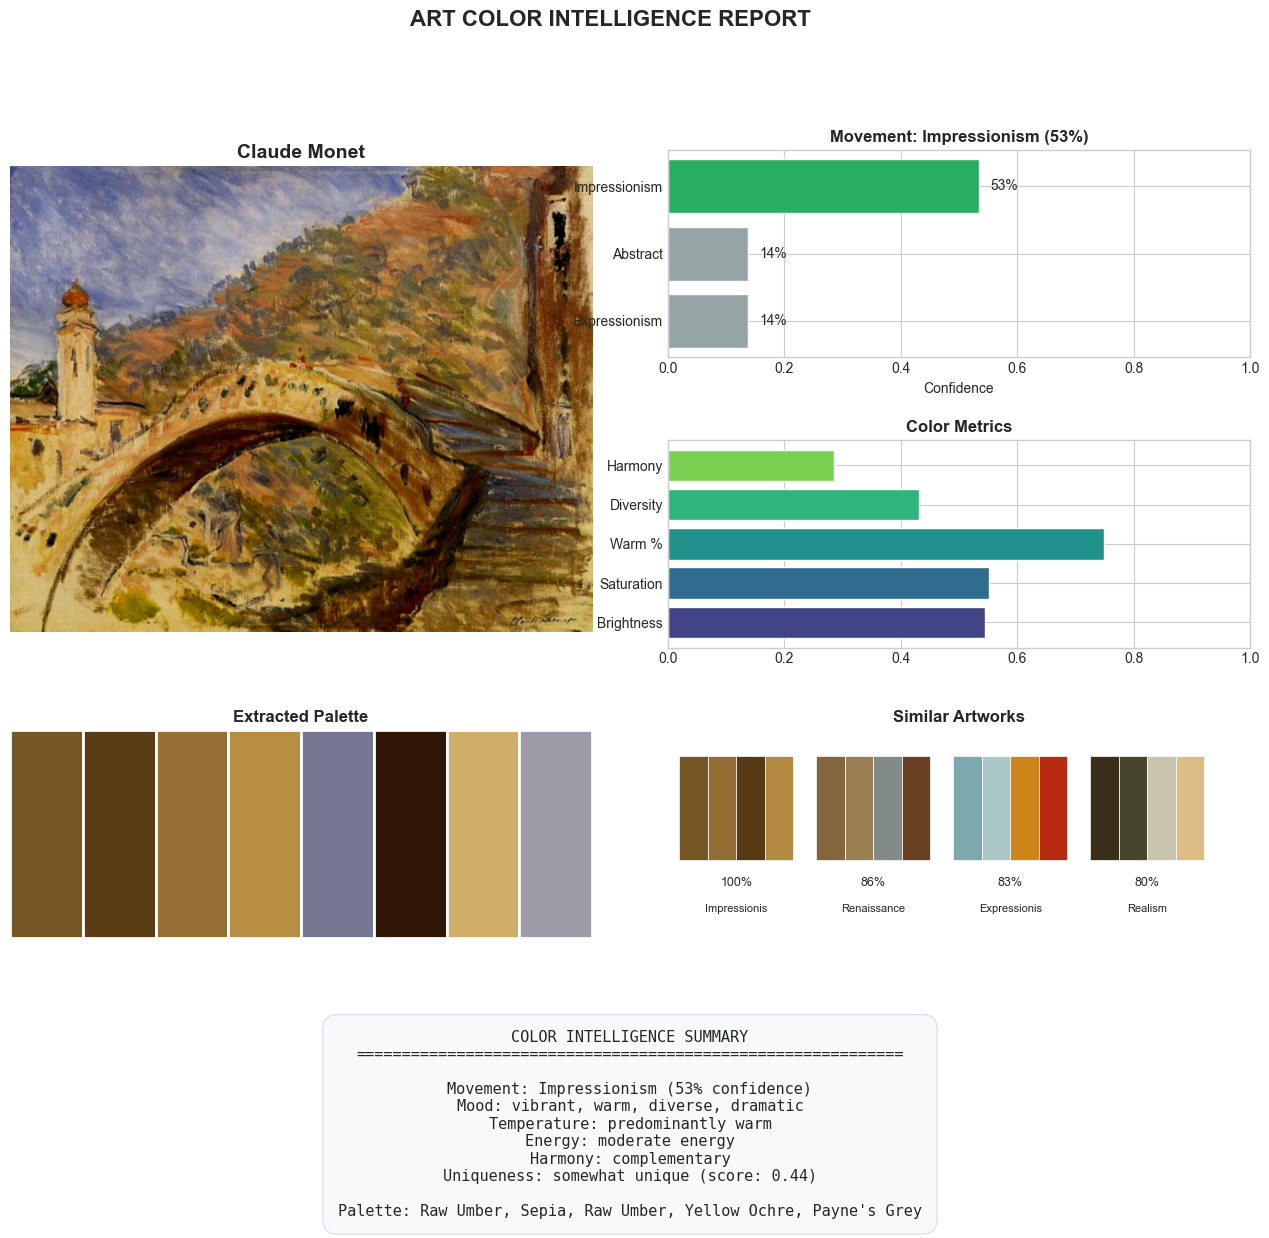

In [8]:
# Test on a Monet
print("Analyzing Claude Monet artwork...")
monet_works = artist_analyzer.extract_artist_works('claude-monet', limit=1)

if monet_works:
    report = report_generator.analyze(monet_works[0]['image'], title="Claude Monet")
    report_generator.print_report()
    report_generator.visualize()

Analyzing Vincent van Gogh artwork...
✓ Found 1 works by vincent-van-gogh

ART COLOR INTELLIGENCE REPORT: Vincent van Gogh

[PALETTE ANALYSIS]
  Colors extracted: 8
  Color names: Raw Sienna, Raw Sienna, Raw Sienna, Raw Umber, Lamp Black
  Dominant harmony: analogous

[COLOR METRICS]
  Brightness: 52.1%
  Saturation: 56.5%
  Warm colors: 100.0%
  Cool colors: 0.0%
  Color diversity: 0.23
  Harmony score: 0.04

[MOVEMENT CLASSIFICATION]
  Predicted: Impressionism
  Confidence: 32.2%
  Top 3:
    - Impressionism: 32.2%
    - Renaissance: 25.1%
    - Cubism: 15.3%

[SIMILAR ARTWORKS]
  1. Renaissance (97% similar)
  2. Impressionism (97% similar)
  3. Cubism (92% similar)

[ANOMALY DETECTION]
  Uniqueness: somewhat unique
  Anomaly score: 0.36
  Is anomaly: No

[MOOD & PSYCHOLOGY]
  Keywords: vibrant, warm, dramatic
  Temperature: predominantly warm
  Energy level: moderate energy



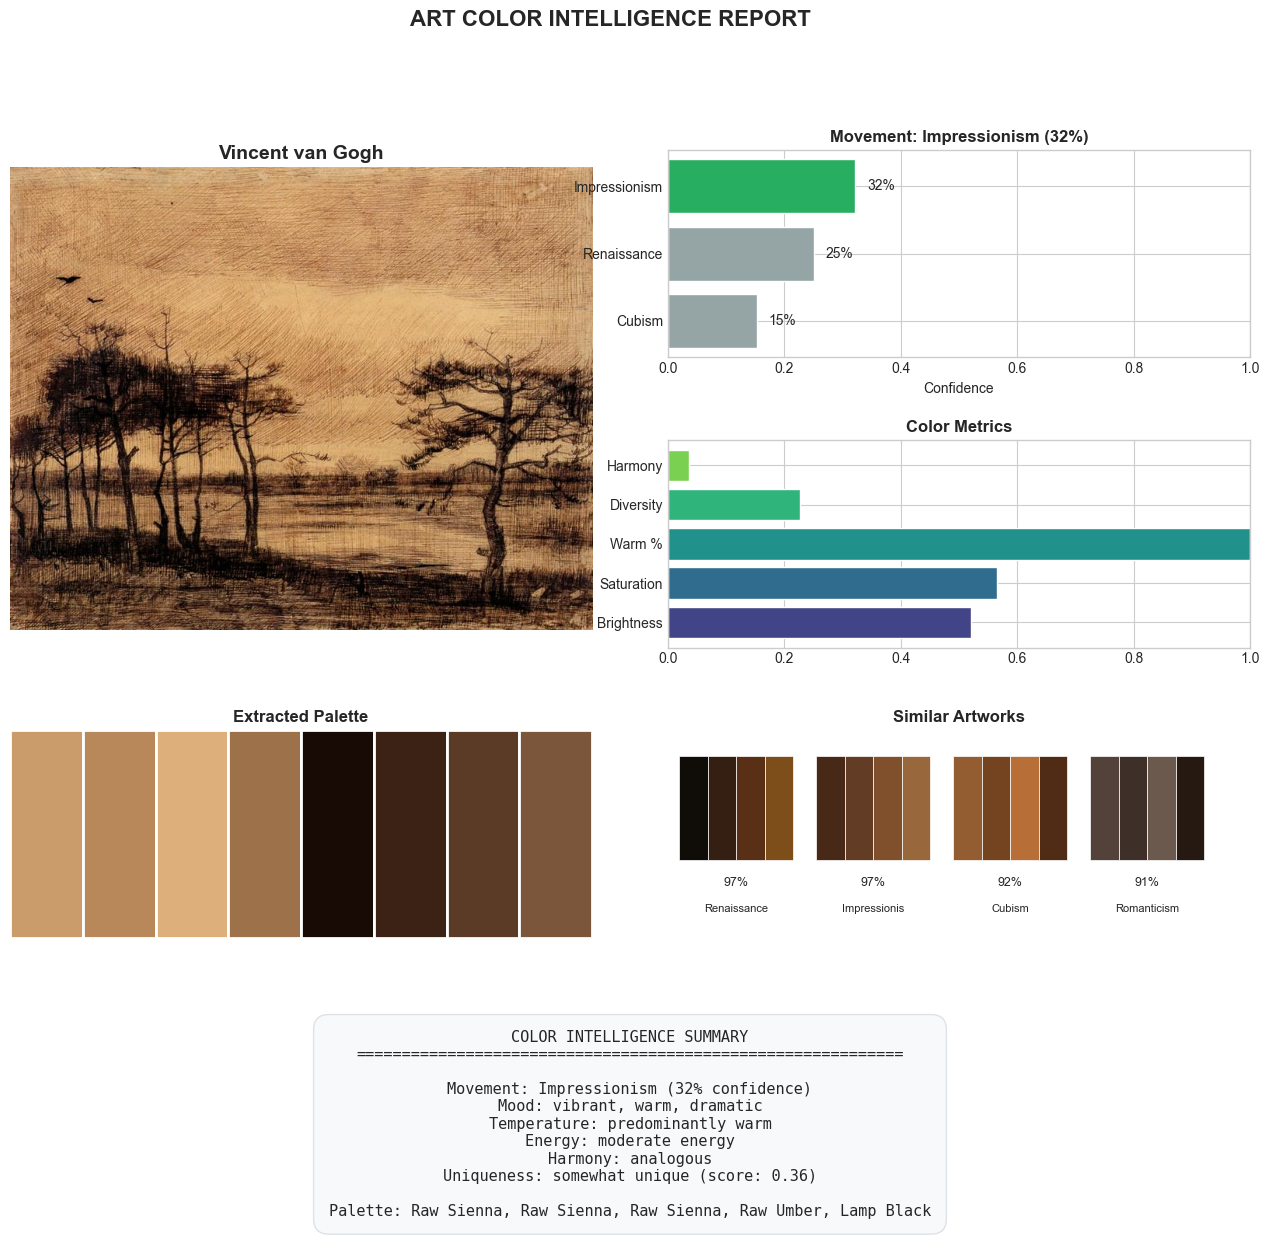

In [9]:
# Test on a Van Gogh
print("Analyzing Vincent van Gogh artwork...")
vangogh_works = artist_analyzer.extract_artist_works('vincent-van-gogh', limit=1)

if vangogh_works:
    report = report_generator.analyze(vangogh_works[0]['image'], title="Vincent van Gogh")
    report_generator.print_report()
    report_generator.visualize()

Analyzing Rembrandt artwork...
✓ Found 1 works by rembrandt

ART COLOR INTELLIGENCE REPORT: Rembrandt

[PALETTE ANALYSIS]
  Colors extracted: 8
  Color names: Ivory Black, Terre Verte, Terre Verte, Raw Umber, Ivory Black
  Dominant harmony: analogous

[COLOR METRICS]
  Brightness: 52.1%
  Saturation: 7.9%
  Warm colors: 12.5%
  Cool colors: 0.0%
  Color diversity: -0.00
  Harmony score: 0.04

[MOVEMENT CLASSIFICATION]
  Predicted: Baroque
  Confidence: 56.0%
  Top 3:
    - Baroque: 56.0%
    - Romanticism: 32.5%
    - Abstract: 5.0%

[SIMILAR ARTWORKS]
  1. Baroque (100% similar)
  2. Romanticism (99% similar)
  3. Romanticism (96% similar)

[ANOMALY DETECTION]
  Uniqueness: somewhat unique
  Anomaly score: 0.43
  Is anomaly: No

[MOOD & PSYCHOLOGY]
  Keywords: muted, focused, dramatic
  Temperature: balanced temperature
  Energy level: calm/subdued



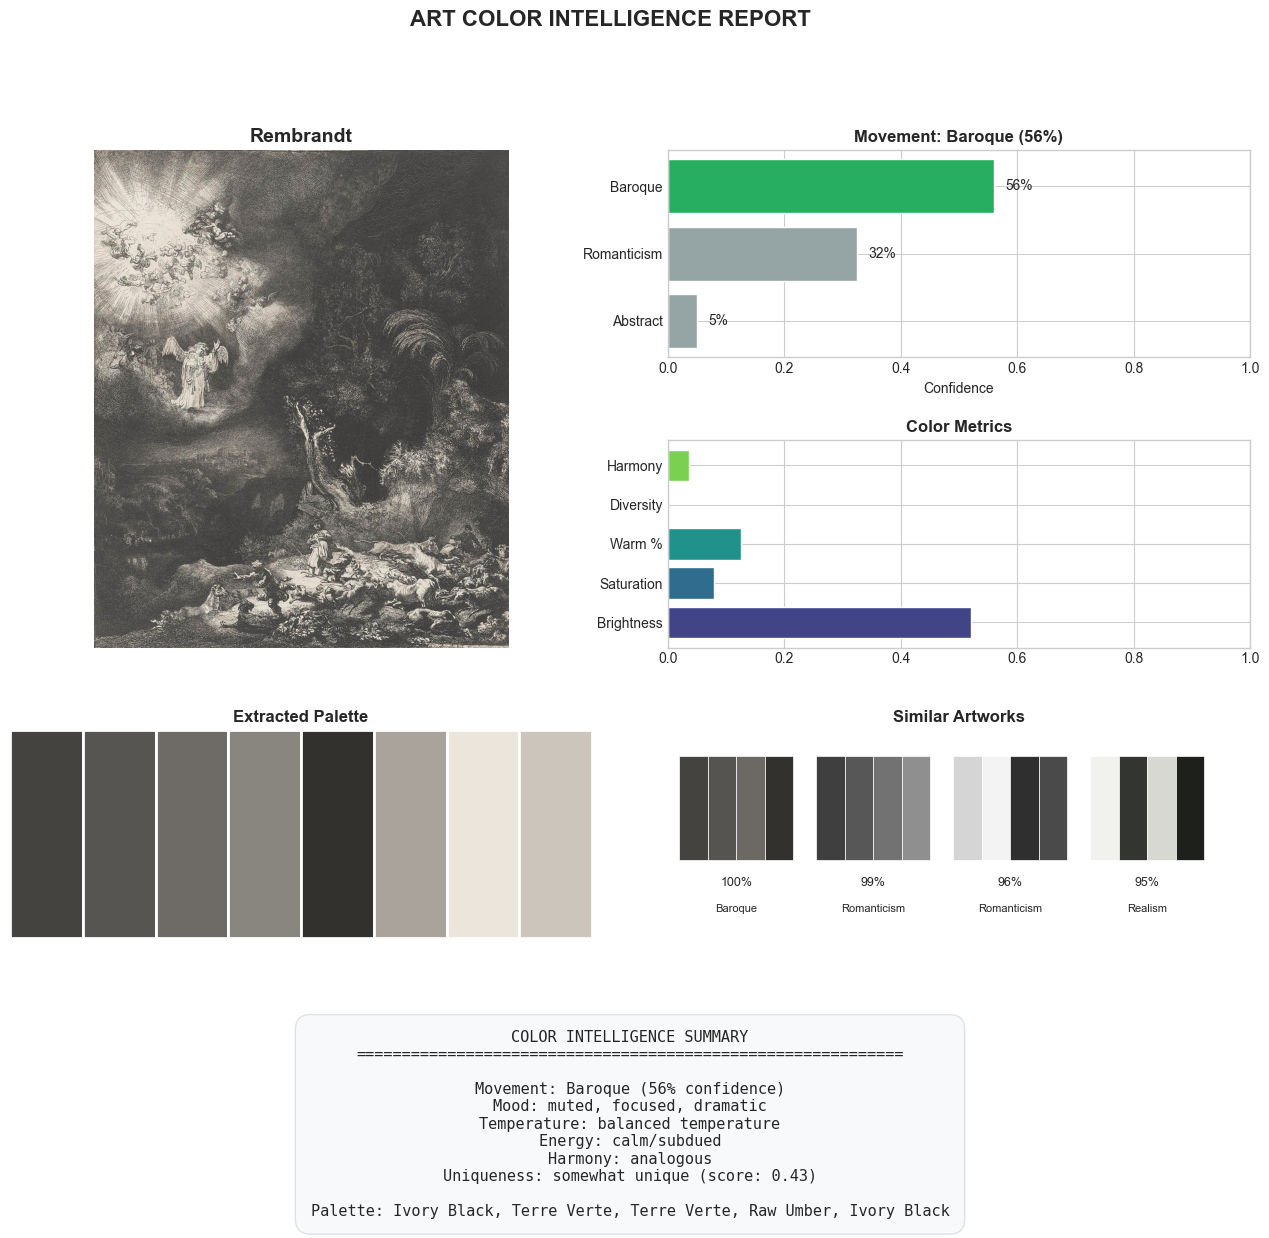

In [10]:
# Test on a Rembrandt
print("Analyzing Rembrandt artwork...")
rembrandt_works = artist_analyzer.extract_artist_works('rembrandt', limit=1)

if rembrandt_works:
    report = report_generator.analyze(rembrandt_works[0]['image'], title="Rembrandt")
    report_generator.print_report()
    report_generator.visualize()

## Part 5: Batch Analysis Tool

Let's create a tool for analyzing multiple artworks at once.

In [11]:
def batch_analyze(artists, works_per_artist=3):
    """
    Analyze multiple artworks and compare results.
    """
    results = []
    
    for artist_name in artists:
        print(f"\nAnalyzing {artist_name}...")
        works = artist_analyzer.extract_artist_works(artist_name, limit=works_per_artist)
        
        for i, work in enumerate(works):
            report = report_generator.analyze(work['image'], title=f"{artist_name} #{i+1}")
            if 'error' not in report:
                results.append({
                    'artist': artist_name,
                    'predicted_movement': report['classification']['predicted_movement'],
                    'confidence': report['classification']['confidence'],
                    'brightness': report['metrics']['brightness'],
                    'saturation': report['metrics']['saturation'],
                    'warm_ratio': report['metrics']['warm_ratio'],
                    'uniqueness': report['anomaly']['uniqueness'],
                    'mood': ', '.join(report['mood']['keywords']),
                })
    
    return pd.DataFrame(results)


# Analyze multiple artists
test_artists = [
    'claude-monet',
    'vincent-van-gogh',
    'rembrandt',
    'pablo-picasso',
    'wassily-kandinsky'
]

batch_results = batch_analyze(test_artists, works_per_artist=2)

print("\n" + "="*80)
print("BATCH ANALYSIS RESULTS")
print("="*80)
print(batch_results.to_string(index=False))


Analyzing claude-monet...
✓ Found 2 works by claude-monet

Analyzing vincent-van-gogh...
✓ Found 2 works by vincent-van-gogh

Analyzing rembrandt...
✓ Found 2 works by rembrandt

Analyzing pablo-picasso...
✓ Found 2 works by pablo-picasso

Analyzing wassily-kandinsky...
⚠ Artist 'wassily-kandinsky' not found in dataset
  Tip: Check spelling and use lowercase with hyphens (e.g., 'claude-monet')

BATCH ANALYSIS RESULTS
          artist predicted_movement  confidence  brightness  saturation  warm_ratio      uniqueness                                     mood
    claude-monet      Impressionism    0.539667   53.823529   55.787166        75.0 somewhat unique         vibrant, warm, diverse, dramatic
    claude-monet      Impressionism    0.580000   61.127451   18.176201        12.5 somewhat unique       luminous, muted, diverse, dramatic
vincent-van-gogh      Impressionism    0.322110   52.156863   56.315888       100.0 somewhat unique                  vibrant, warm, dramatic
vincent-van-go

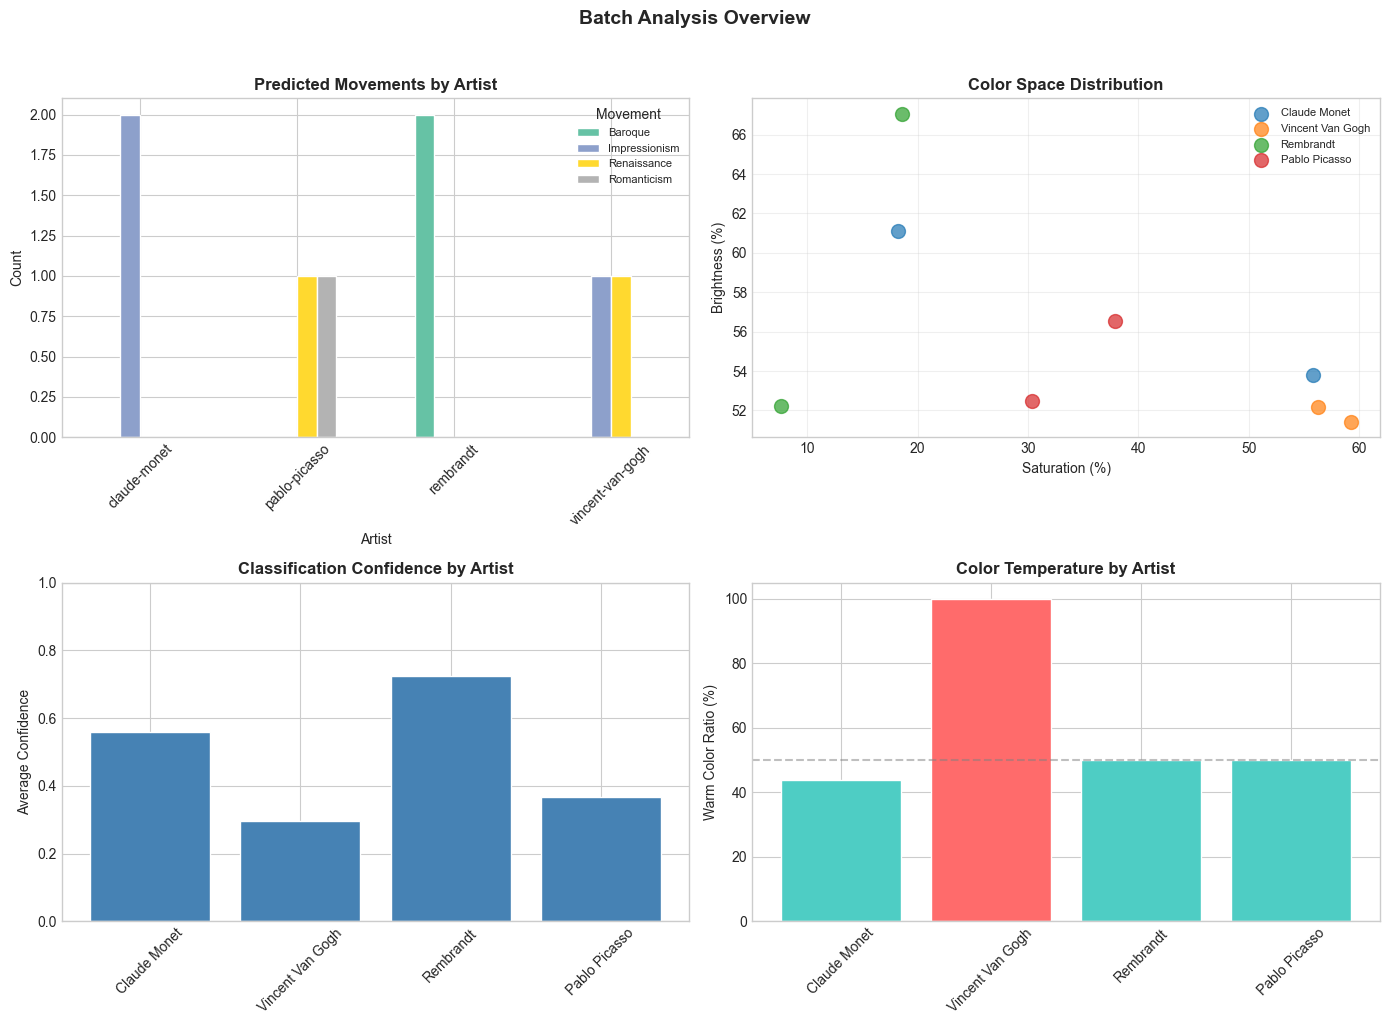

In [12]:
# Visualize batch results
if len(batch_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Predictions by artist
    ax = axes[0, 0]
    prediction_counts = batch_results.groupby(['artist', 'predicted_movement']).size().unstack(fill_value=0)
    prediction_counts.plot(kind='bar', ax=ax, colormap='Set2')
    ax.set_title('Predicted Movements by Artist', fontsize=12, fontweight='bold')
    ax.set_xlabel('Artist')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Movement', fontsize=8)
    
    # 2. Brightness vs Saturation
    ax = axes[0, 1]
    for artist in batch_results['artist'].unique():
        artist_data = batch_results[batch_results['artist'] == artist]
        ax.scatter(artist_data['saturation'], artist_data['brightness'], 
                  s=100, alpha=0.7, label=artist.replace('-', ' ').title())
    ax.set_xlabel('Saturation (%)')
    ax.set_ylabel('Brightness (%)')
    ax.set_title('Color Space Distribution', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # 3. Confidence distribution
    ax = axes[1, 0]
    artists = batch_results['artist'].unique()
    confidences = [batch_results[batch_results['artist'] == a]['confidence'].mean() for a in artists]
    ax.bar([a.replace('-', ' ').title() for a in artists], confidences, color='steelblue')
    ax.set_ylabel('Average Confidence')
    ax.set_title('Classification Confidence by Artist', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, 1)
    
    # 4. Warm ratio comparison
    ax = axes[1, 1]
    warm_ratios = [batch_results[batch_results['artist'] == a]['warm_ratio'].mean() for a in artists]
    colors = ['#ff6b6b' if w > 50 else '#4ecdc4' for w in warm_ratios]
    ax.bar([a.replace('-', ' ').title() for a in artists], warm_ratios, color=colors)
    ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylabel('Warm Color Ratio (%)')
    ax.set_title('Color Temperature by Artist', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    
    plt.suptitle('Batch Analysis Overview', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

## Part 6: Interactive Analysis Function

A simple function for quick analysis of any artwork.

In [13]:
def analyze_artwork(image_source, title="Artwork", visualize=True, print_report=True):
    """
    Quick analysis function for any artwork.
    
    Args:
        image_source: PIL Image, file path, or artist name (e.g., 'claude-monet')
        title: Title for the report
        visualize: Whether to show visualization
        print_report: Whether to print text report
        
    Returns:
        Report dictionary
    """
    # Handle different input types
    if isinstance(image_source, str):
        if '.' in image_source or '/' in image_source:
            # File path
            image = Image.open(image_source)
        else:
            # Artist name
            works = artist_analyzer.extract_artist_works(image_source, limit=1)
            if not works:
                print(f"No works found for artist: {image_source}")
                return None
            image = works[0]['image']
            title = image_source.replace('-', ' ').title()
    else:
        image = image_source
    
    # Generate report
    report = report_generator.analyze(image, title=title)
    
    if 'error' in report:
        print(f"Error: {report['error']}")
        return report
    
    if print_report:
        report_generator.print_report()
    
    if visualize:
        report_generator.visualize()
    
    return report


# Example usage
print("analyze_artwork() function ready!")
print("\nUsage examples:")
print("  analyze_artwork('claude-monet')")
print("  analyze_artwork('path/to/image.jpg')")
print("  analyze_artwork(pil_image, title='My Artwork')")

analyze_artwork() function ready!

Usage examples:
  analyze_artwork('claude-monet')
  analyze_artwork('path/to/image.jpg')
  analyze_artwork(pil_image, title='My Artwork')


✓ Found 1 works by henri-matisse

ART COLOR INTELLIGENCE REPORT: Henri Matisse

[PALETTE ANALYSIS]
  Colors extracted: 8
  Color names: Lamp Black, Ivory Black, Ivory Black, Raw Umber, Zinc White
  Dominant harmony: analogous

[COLOR METRICS]
  Brightness: 49.0%
  Saturation: 16.7%
  Warm colors: 75.0%
  Cool colors: 0.0%
  Color diversity: 0.51
  Harmony score: 0.04

[MOVEMENT CLASSIFICATION]
  Predicted: Baroque
  Confidence: 35.8%
  Top 3:
    - Baroque: 35.8%
    - Renaissance: 14.5%
    - Realism: 11.5%

[SIMILAR ARTWORKS]
  1. Abstract (82% similar)
  2. Expressionism (81% similar)
  3. Realism (80% similar)

[ANOMALY DETECTION]
  Uniqueness: somewhat unique
  Anomaly score: 0.39
  Is anomaly: No

[MOOD & PSYCHOLOGY]
  Keywords: muted, warm, diverse, dramatic
  Temperature: predominantly warm
  Energy level: moderate energy



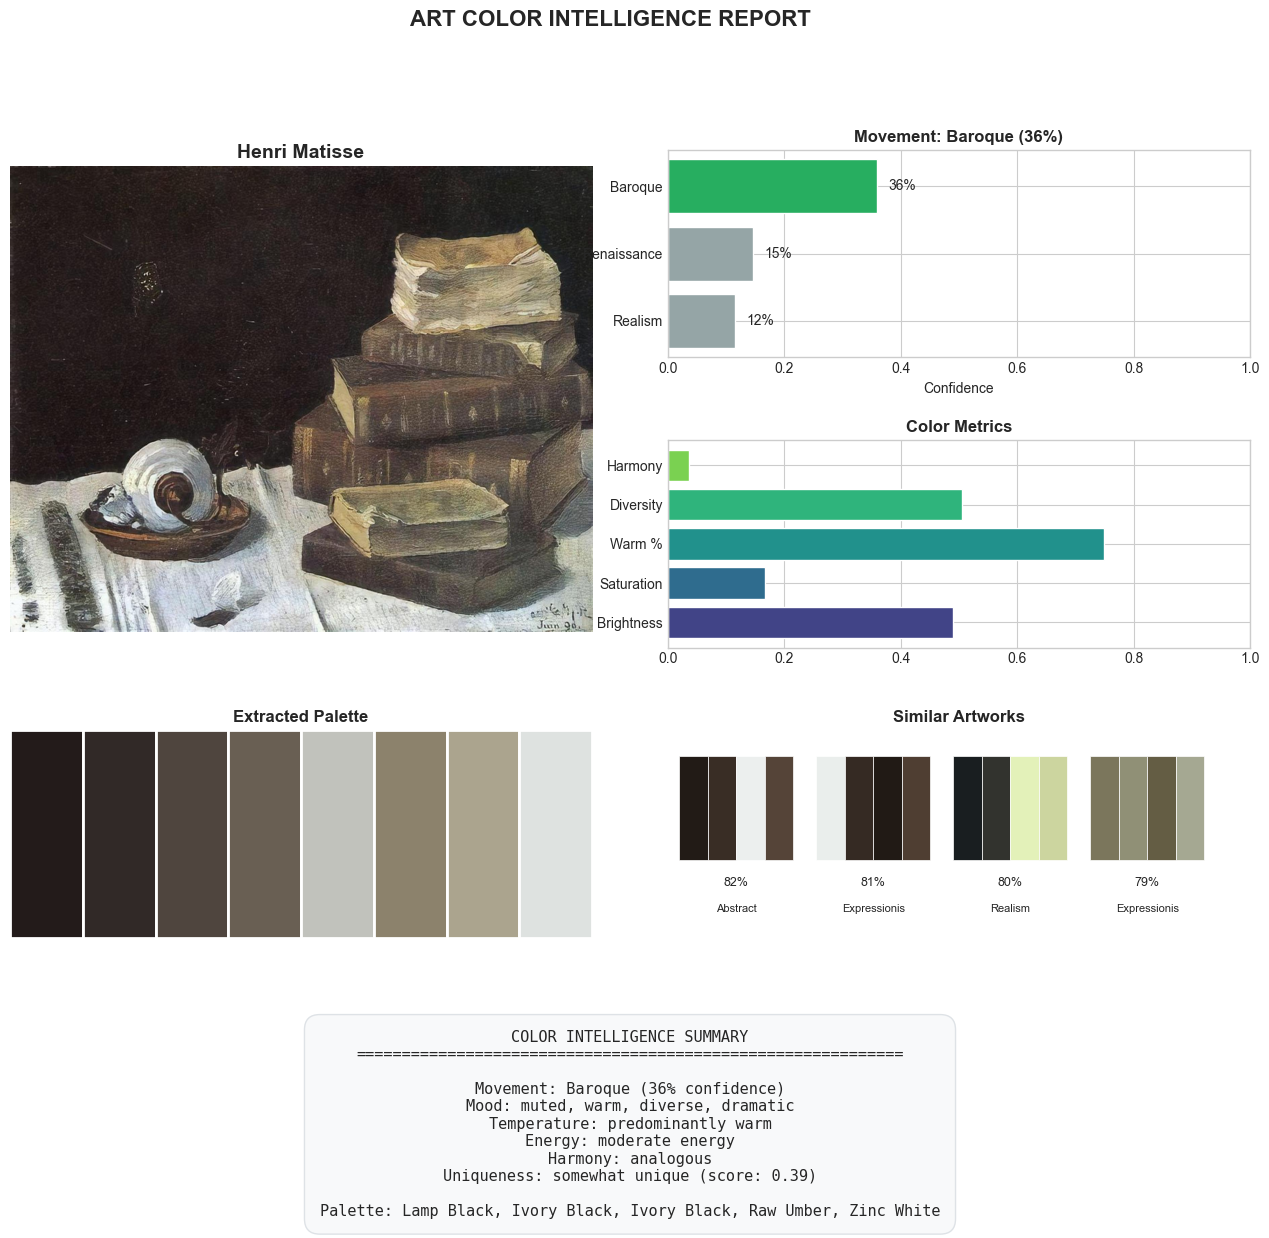

In [14]:
# Try it out!
report = analyze_artwork('henri-matisse')

## Part 7: Export Functionality

Let's add the ability to export reports.

In [15]:
def export_report_to_dict(report):
    """
    Export report to a JSON-serializable dictionary.
    """
    if report is None or 'error' in report:
        return report
    
    # Create exportable version (remove non-serializable items)
    export = {
        'title': report['title'],
        'timestamp': report['timestamp'],
        'palette': {
            'colors': [list(c) for c in report['palette']['colors']],
            'color_names': report['palette']['color_names'],
            'dominant_harmony': report['palette']['dominant_harmony'],
        },
        'metrics': report['metrics'],
        'classification': {
            'predicted_movement': report['classification']['predicted_movement'],
            'confidence': float(report['classification']['confidence']),
            'top_3': [(m, float(p)) for m, p in report['classification']['top_3']],
        },
        'similar': [
            {'style': s['style'], 'similarity': float(s['similarity'])}
            for s in report['similar']
        ],
        'anomaly': {
            'is_anomaly': bool(report['anomaly']['is_anomaly']),
            'anomaly_score': float(report['anomaly']['anomaly_score']),
            'uniqueness': report['anomaly']['uniqueness'],
        },
        'mood': report['mood'],
    }
    
    return export


def save_report_json(report, filepath):
    """
    Save report to JSON file.
    """
    import json
    
    export = export_report_to_dict(report)
    
    with open(filepath, 'w') as f:
        json.dump(export, f, indent=2)
    
    print(f"Report saved to: {filepath}")


# Example
if report:
    export_data = export_report_to_dict(report)
    print("\nExportable report keys:")
    print(list(export_data.keys()))


Exportable report keys:
['title', 'timestamp', 'palette', 'metrics', 'classification', 'similar', 'anomaly', 'mood']


## Part 8: Summary & Course Completion

### What You Built

In this capstone project, you created a complete **Art Color Intelligence Platform** that:

1. **Extracts** comprehensive color features from any artwork
2. **Names** colors using artistic vocabulary
3. **Classifies** artwork by probable art movement
4. **Finds** similar artworks based on color similarity
5. **Detects** unusual/anomalous color usage
6. **Analyzes** mood and psychological associations
7. **Generates** beautiful visual reports
8. **Exports** results for further use

### Skills Applied

| Lesson | Technique | Application |
|--------|-----------|-------------|
| 1-3 | Extraction, color spaces | `ColorFeatureEngine` |
| 4-6 | Signatures, harmony | Quality metrics |
| 7-9 | Pipelines, psychology | Report generation |
| 10-11 | Classification, naming | `predict_movement()`, `name_palette()` |
| 12 | SHAP explainability | Feature importance |
| 14 | Artist DNA | `find_similar()` |
| 15 | Anomaly detection | `detect_anomaly()` |

### Next Steps

To take this further, you could:

1. **Build a web app** using Streamlit or Gradio
2. **Add more models** (VAE generation, temporal analysis)
3. **Create an API** for integration with other tools
4. **Train on more data** for better accuracy
5. **Add image upload** functionality

In [16]:
# Final demonstration
print("\n" + "="*70)
print("CAPSTONE PROJECT COMPLETE!")
print("="*70)
print("\nYour Art Color Intelligence Platform is ready.")
print("\nQuick usage:")
print("  report = analyze_artwork('artist-name')")
print("  report = analyze_artwork('path/to/image.jpg')")
print("\nComponents available:")
print("  - feature_engine: Extract color features")
print("  - models: Classification, similarity, anomaly detection")
print("  - report_generator: Full analysis reports")
print("  - batch_analyze(): Analyze multiple artworks")
print("  - export_report_to_dict(): Export for JSON/API")


CAPSTONE PROJECT COMPLETE!

Your Art Color Intelligence Platform is ready.

Quick usage:
  report = analyze_artwork('artist-name')
  report = analyze_artwork('path/to/image.jpg')

Components available:
  - feature_engine: Extract color features
  - models: Classification, similarity, anomaly detection
  - report_generator: Full analysis reports
  - batch_analyze(): Analyze multiple artworks
  - export_report_to_dict(): Export for JSON/API


## Exercises: Extend Your Platform

In [17]:
# YOUR CODE HERE

# Exercise 1: Add VAE palette generation
# Generate palettes in the style of the analyzed artwork

# Exercise 2: Add temporal estimation
# Predict the probable decade/era of creation

# Exercise 3: Build a Streamlit web app
# Create an interactive interface for your platform

# Exercise 4: Add artist prediction
# "This looks most like the work of..."

# Exercise 5: Create a comparison tool
# Compare two artworks side-by-side


---

## Course Conclusion

# Congratulations! 🎉

You have completed the **Color Analysis with Renoir** course!

Over 17 lessons, you've journeyed from basic color extraction to building a complete AI-powered art analysis platform:

### Course Summary

| Module | Lessons | Topics |
|--------|---------|--------|
| **Fundamentals** | 1-3 | Palette extraction, color spaces, comparison |
| **Intermediate** | 4-6 | Signatures, harmony, thematic analysis |
| **Advanced** | 7-9 | Pipelines, evolution, psychology |
| **ML Introduction** | 10-11 | Classification, color naming |
| **Deep Learning** | 12-13 | SHAP explainability, VAE generation |
| **Embeddings** | 14 | Artist DNA, recommendations |
| **Unsupervised** | 15 | Clustering, anomaly detection |
| **Temporal** | 16 | Evolution, period detection |
| **Capstone** | 17 | Complete intelligence platform |

### What You Can Now Do

- Extract and analyze color palettes from any artwork
- Classify art by movement using machine learning
- Find similar artworks and artists
- Generate new palettes with VAEs
- Detect anomalies and outliers
- Track artistic evolution over time
- Build complete analysis pipelines

### Keep Exploring!

Art and data science are both infinite fields. Keep experimenting, keep learning, and keep creating.

**Thank you for taking this course!**